# Error analysis on San Jose Census Block Groups

In [3]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, visualize_tile_predvOSM, assign_cbgs_by_coverage

In [4]:
import json
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj
from pyproj import Geod
import rasterio
import rasterio.plot
from rasterio.transform import from_bounds
import rasterio.features
import seaborn as sns
import shapely
from shapely.geometry import box, Polygon, Point
from shapely.ops import orient
from tqdm import tqdm
import pickle
import matplotlib.image as mpimg
import matplotlib.patches as patches

tqdm.pandas()

In [5]:
cf_fp = '/oak/stanford/groups/deho/building_compliance/CloudFactory/'
cf_exports = os.path.join(cf_fp, 'exports', 'Batch1_48')
cf_images = os.path.join(cf_fp, 'images')

In [6]:
with open(os.path.join(cf_images, "img_metadata.p"), "rb") as output_file:
    img_metadata = pickle.load(output_file)

FileNotFoundError: [Errno 2] No such file or directory: '/oak/stanford/groups/deho/building_compliance/CloudFactory/images/img_metadata.p'

In [32]:
df = pd.DataFrame(columns=['apn', 'year', 'geometry'])

for i in tqdm(os.listdir(cf_exports)):
    apn = i.split('.')[0]
    image = mpimg.imread(os.path.join(cf_images, 'Batch1', 'images', f'{apn}.png'))
    
    #assert apn in img_metadata #####!!!!!! Adding to skip parcels
    if not apn in img_metadata:
        continue 
    
    lons = img_metadata[apn]['lons']
    lats = img_metadata[apn]['lats']
    
    with open(os.path.join(cf_exports, i), 'r') as f:
        parcel_label = json.load(f)
        
        # get image height and width
        height = parcel_label['metadata']['system']['height']
        width = parcel_label['metadata']['system']['width']
        
        # height will not have any buffer
        #assert len(lats)*2 == height #####!!!!!! Adding to skip parcels
        if not len(lats)*2 == height:
            continue
        buffer = width - len(lons)*2

        if parcel_label['annotated']:
            assert parcel_label["annotationsCount"] > 0
            assert parcel_label["annotationsCount"] == len(parcel_label['annotations'])
            show = False
#             fig, ax = plt.subplots()
#             ax.imshow(image)

            for label in parcel_label['annotations']:
                # ignore all labels that are "blank"
                if label['label'] == 'small_building':
                    # i think there are some mislabels -- small_buildings not having coordinate key
                    if 'coordinates' in label:
                        coords = label['coordinates']
                        assert len(coords) == 1

                        coords = coords[0]
                        
                        show = True
                        coords_raw0 = [(round(i['x']), round(i['y'])) for i in coords]
                        x = [round(i['x']) for i in coords]
                        min_x = min(x)
                        max_x = max(x)
                        y = [round(i['y']) for i in coords]
                        min_y = min(y)
                        max_y = max(y)
                        rect = patches.Rectangle((min_x, min_y), max_x-min_x, max_y-min_y, linewidth=1, edgecolor='r', facecolor='none')
#                         ax.add_patch(rect)
                        
                        
                        coords_raw = [(round(i['x']), round(i['y'])-len(lats)) for i in coords]
#                         print(coords_raw)
                        is_2016 = True
                        test_x = [i[0] > len(lons) for i in coords_raw]
                        test_y = [i[1] <= len(lats) for i in coords_raw]
                        
                        if all(test_x):
                            is_2016 = False
                            # if 2020, then adjust x by buffer
                            coords_raw = [(i[0]-len(lons)-buffer, i[1]) for i in coords_raw]
                        else:
                            if any(test_x):
                                print('Wrong behavior')
                        
                        # this is to ensure that the pixel count starts from 1 rather than 0
                        est_g0 = [i[0] > 3 for i in coords_raw] + [i[1] > 0 for i in coords_raw]
                        
                        assert all(test_y)
                        #assert all(est_g0)
                        if not all(est_g0): #####!!!!!! Adding this to skip a given annotation
                            continue
                        
                                
                        # convert pixel coords into 26910
#                         coords_26910 = [[lons[i[0]-1], lats[i[1]]-1] for i in coords_raw]
                        
    
                        """
                        There is a systematic error when we displace by 1 like above -- not sure why tbh!
                        - x-4 and keeping y as is leads to the most accurate behavior, but this is hacky
                        """
                        coords_26910 = [[lons[i[0]-4], lats[i[1]]] for i in coords_raw]
                        polygon_26910 = Polygon(coords_26910)
                        
                        wgs84 = pyproj.CRS('EPSG:26910')
                        utm = pyproj.CRS('EPSG:4326')
                        project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

                        # convert
                        polygon_4326 = shapely.ops.transform(project, polygon_26910)
                        
                        ## NEED TO CHECK IF COORDS ARE ACCURATE
#                         print(polygon_4326)
                        year = '2016' if is_2016 else '2020'
                        df.loc[len(df)] = [apn, year, polygon_4326]
#             if show:
#                 plt.show()
#             else:
#                 plt.clf()           
                            
        else:
            #print(apn)
            assert parcel_label['annotationsCount'] == 0

100%|██████████| 2666/2666 [03:58<00:00, 11.20it/s]  


In [33]:
df.head()

,apn,year,geometry
0,29930028,2020,POLYGON ((-121.96207624609107 37.3102504769624...
1,29930028,2016,POLYGON ((-121.96206274349876 37.3102476544563...
2,42910002,2016,POLYGON ((-121.90617964241505 37.3042604483126...
3,42910002,2020,POLYGON ((-121.90618971791973 37.3042659495596...
4,44626008,2016,POLYGON ((-121.9037079017131 37.28984656643558...


In [34]:
df = gpd.GeoDataFrame(df, crs='EPSG:4326')
df['area'] = df.to_crs('EPSG:26910').geometry.area

In [35]:
df.rename(columns={'apn': 'APN'}, inplace=True)

In [36]:
# Save df
df.to_file(os.path.join(cf_fp, 'results', 'Batch1_48', 'extracted_poly'))

# Test parcels

In [7]:
df = gpd.read_file(os.path.join(cf_fp, 'results', 'Batch1_48', 'extracted_poly'))

In [8]:
# Check parcels
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
sj_parcels_res = gpd.read_file(os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs', 'sj-parcels-res-cbgs'))


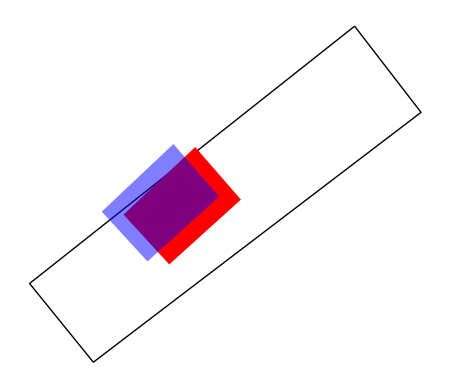

In [15]:
parcel_apn='43422021'
parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

fig, ax = plt.subplots()
parcel_bounds.plot(ax=ax, facecolor='none')
df.loc[(df['APN'] == parcel_apn) & (df['year'] == '2016')].plot(ax=ax, color='red')
df.loc[(df['APN'] == parcel_apn) & (df['year'] == '2020')].plot(ax=ax, color='blue', alpha=0.5)

ax.axis('off')
plt.show()